In [1]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from task_5_core.lvq import LVQ 

2023-11-27 16:58:53.721292: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 16:58:53.723496: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 16:58:53.752927: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 16:58:53.752956: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 16:58:53.752979: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = list(map(lambda arr: arr.reshape(784).astype('float64'), train_images))
test_images = list(map(lambda arr: arr.reshape(784).astype('float64'), test_images))

train_data, test_data = (train_images, train_labels), (test_images, test_labels)

In [3]:
def train_and_test(train_data, test_data, pattern_split=0.01, epochs=1, alpha=0.01, learning_rule='classic'):
    model = LVQ()

    patterns_count = int(len(train_data[0]) * pattern_split)
    init_data = (train_data[0][:patterns_count], train_data[1][:patterns_count])
    
    
    fit_data = (train_data[0][patterns_count:], train_data[1][patterns_count:])
    model.train(init_data, fit_data, learning_rule, alpha, epochs)

    features, labels = test_data 
    predictions = model.predict(features)

    metrics = (
        accuracy_score(labels, predictions),
        f1_score(labels, predictions, average='macro'),
        recall_score(labels, predictions, average='macro', zero_division=0),
        precision_score(labels, predictions, average='macro', zero_division=0)
    )
    return metrics

In [4]:
pattern_split_options = [0.0001, 0.001, 0.0025]
epochs_options = [1, 2, 5]
alpha_options = [0.001, 0.01, 0.05]
learning_rules = ['classic', 'two_step']
options = set(itertools.product(pattern_split_options, epochs_options, alpha_options, learning_rules))

def pattern_split_metrics():
    return {pattern_split: {} for pattern_split in pattern_split_options}

def epochs_metrics(): 
    return {epochs: pattern_split_metrics() for epochs in epochs_options}

def alpha_metrics():
    return {alpha: epochs_metrics() for alpha in alpha_options}

history = {rule: alpha_metrics() for rule in learning_rules}

for pattern_split, epochs, alpha, learning_rule in options:
    metrics = train_and_test(train_data, test_data, pattern_split=pattern_split, epochs=epochs, alpha=alpha, learning_rule=learning_rule)
    history[learning_rule][alpha][epochs][pattern_split] = metrics

In [5]:
rows = {'rule': [], 'alpha': [], 'epoch': [], 'pattern': [], 'accuracy': [], 'f1': [], 'recall': [], 'precision': []}
for rule in learning_rules:
    for alpha in alpha_options:
        for epoch in epochs_options:
            for pattern in pattern_split_options:
                m = history[rule][alpha][epoch][pattern]
                print(f'For rule: {rule}, alpha: {alpha}, epoch: {epoch}, pattern: {pattern}\n'
                      f'Accuracy = {m[0]}, F1 = {m[1]}, Recall = {m[2]}, Precision = {m[3]}')
                values = {'rule': rule, 'alpha': alpha, 'epoch': epoch, 'pattern': pattern,
                          'accuracy': m[0], 'f1': m[1], 'recall': m[2], 'precision': m[3]}
                for key, value in values.items():
                    rows[key].append(value)
result_df = pd.DataFrame.from_dict(rows).sort_values(['accuracy'], ascending=False)
result_df.head(len(result_df))

For rule: classic, alpha: 0.001, epoch: 1, pattern: 0.0001
Accuracy = 0.4919, F1 = 0.3794164289991412, Recall = 0.4866840993352629, Precision = 0.3233946714417022
For rule: classic, alpha: 0.001, epoch: 1, pattern: 0.001
Accuracy = 0.8743, F1 = 0.8734795867411307, Recall = 0.8726537364475545, Precision = 0.8805930718767156
For rule: classic, alpha: 0.001, epoch: 1, pattern: 0.0025
Accuracy = 0.9149, F1 = 0.9137497188498409, Recall = 0.9134728428246648, Precision = 0.915697332854374
For rule: classic, alpha: 0.001, epoch: 2, pattern: 0.0001
Accuracy = 0.4918, F1 = 0.37896516919051026, Recall = 0.4868120227772149, Precision = 0.3208060002827685
For rule: classic, alpha: 0.001, epoch: 2, pattern: 0.001
Accuracy = 0.8524, F1 = 0.8501570986679731, Recall = 0.849674277948305, Precision = 0.8568504619860313
For rule: classic, alpha: 0.001, epoch: 2, pattern: 0.0025
Accuracy = 0.8858, F1 = 0.8847347640894915, Recall = 0.8840780410607019, Precision = 0.8895793948240452
For rule: classic, alpha:

,rule,alpha,epoch,pattern,accuracy,f1,recall,precision
17,classic,0.010,5,0.0025,0.9229,0.922103,0.921786,0.923263
29,two_step,0.001,1,0.0025,0.9223,0.921111,0.921136,0.922082
44,two_step,0.010,5,0.0025,0.9221,0.920914,0.920952,0.921915
8,classic,0.001,5,0.0025,0.9208,0.919820,0.919387,0.921598
14,classic,0.010,2,0.0025,0.9199,0.918782,0.918357,0.920387
50,two_step,0.050,2,0.0025,0.9153,0.914083,0.913815,0.915471
2,classic,0.001,1,0.0025,0.9149,0.913750,0.913473,0.915697
38,two_step,0.010,1,0.0025,0.9146,0.913445,0.913507,0.914390
35,two_step,0.001,5,0.0025,0.9109,0.909664,0.909805,0.910901
26,classic,0.050,5,0.0025,0.9107,0.909491,0.909146,0.911732


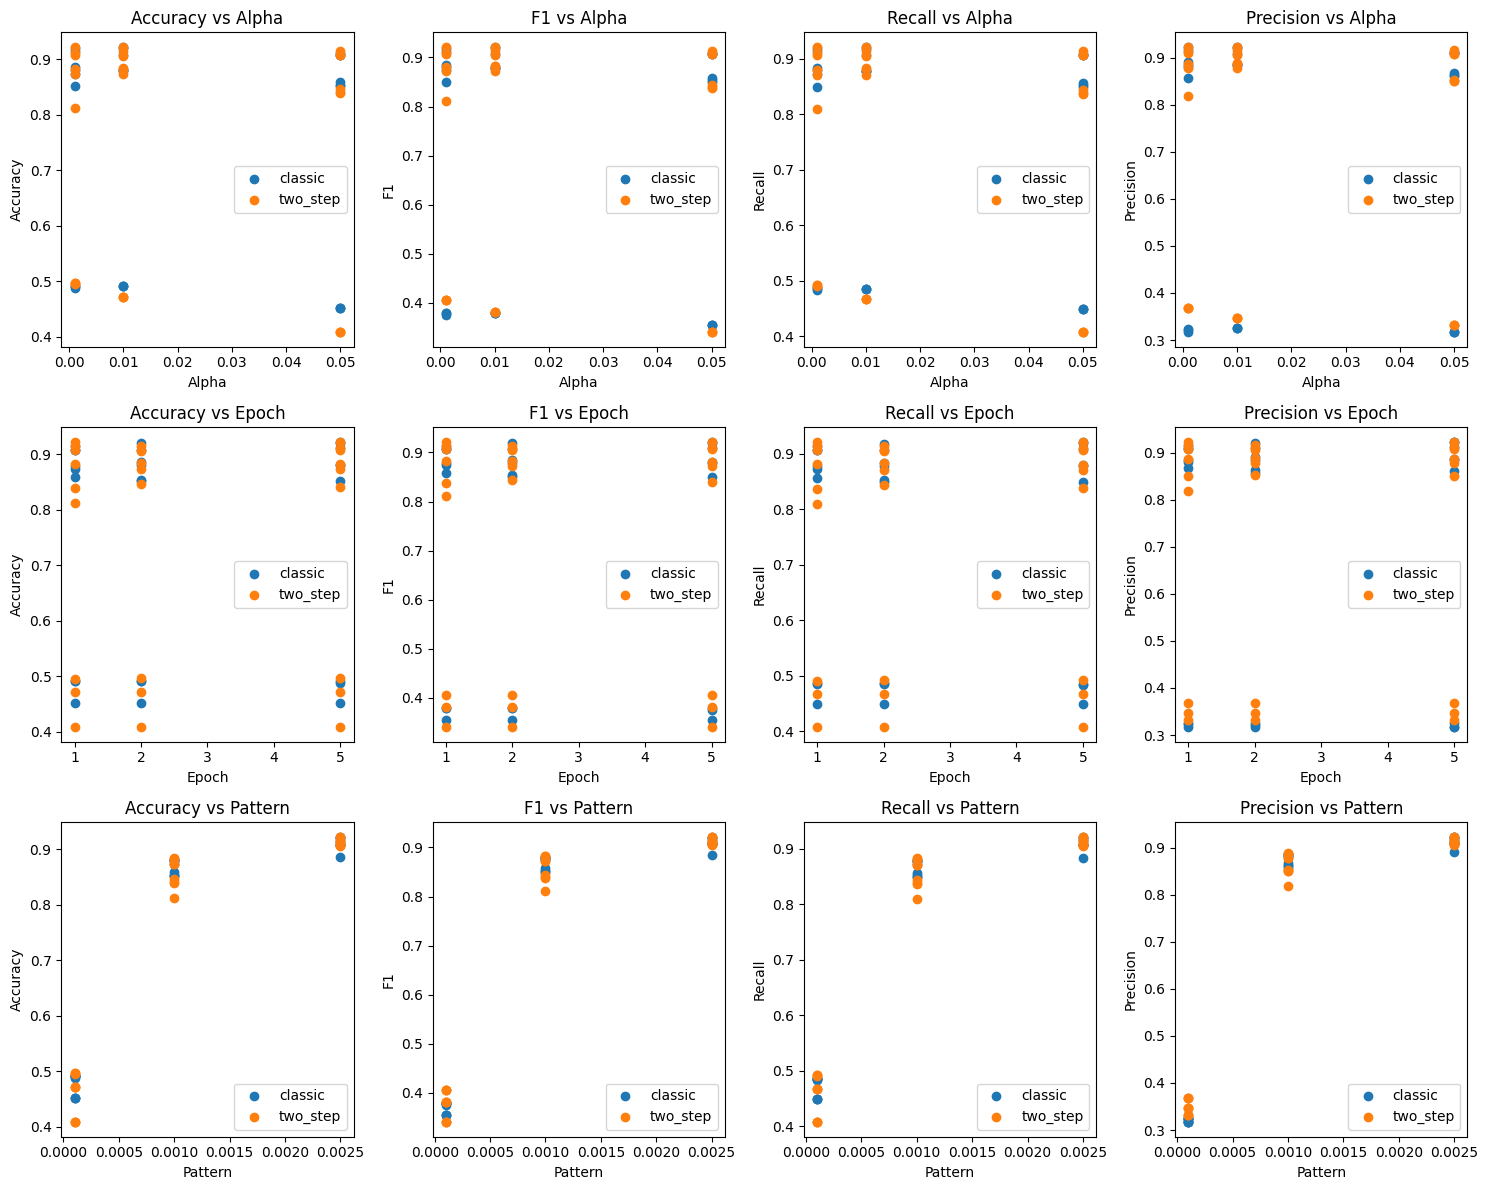

In [6]:
hyperparameters_to_visualize = ['alpha', 'epoch', 'pattern']
metrics_to_visualize = ['accuracy', 'f1', 'recall', 'precision']

fig, axes = plt.subplots(nrows=len(hyperparameters_to_visualize), ncols=len(metrics_to_visualize), figsize=(15, 12))

for i, hyperparam in enumerate(hyperparameters_to_visualize):
    for j, metric in enumerate(metrics_to_visualize):
        ax = axes[i, j]
        ax.set_title(f'{metric.capitalize()} vs {hyperparam.capitalize()}')
        ax.set_xlabel(hyperparam.capitalize())
        ax.set_ylabel(metric.capitalize())

        for rule in result_df['rule'].unique():
            rule_data = result_df[result_df['rule'] == rule]
            ax.scatter(rule_data[hyperparam], rule_data[metric], label=rule)

        ax.legend()

plt.tight_layout()
plt.show()

 According to the results, the best performance is shown by classic update approach, which means that finding the closest vector in wrong train case and increase it's weight does not positively impact performance in our case. 
Additionaly, highest performance is shown in test cases, where either 1 or 5 epochs are used, with alpha =0.01 or 0.001. 0.05 is only present in 1 test scenario with relatiely high performance for two_step rule.

High performance is only achieved with pattern split with either 0.001 or 0.0025 for all 0.0001 values we have accuracy <10%.

rule: classic, alpha: 0.001
{0.0001: (0.4919, 0.3794164289991412, 0.4866840993352629, 0.3233946714417022), 0.001: (0.8743, 0.8734795867411307, 0.8726537364475545, 0.8805930718767156), 0.0025: (0.9149, 0.9137497188498409, 0.9134728428246648, 0.915697332854374)}
{0.0001: (0.4918, 0.37896516919051026, 0.4868120227772149, 0.3208060002827685), 0.001: (0.8524, 0.8501570986679731, 0.849674277948305, 0.8568504619860313), 0.0025: (0.8858, 0.8847347640894915, 0.8840780410607019, 0.8895793948240452)}
{0.0001: (0.4875, 0.37583200499718983, 0.4823201470240538, 0.3179993301936221), 0.001: (0.8808, 0.8796063847178358, 0.8790261845936854, 0.8845248108954202), 0.0025: (0.9208, 0.9198200893002649, 0.9193867260508032, 0.9215981752488001)}


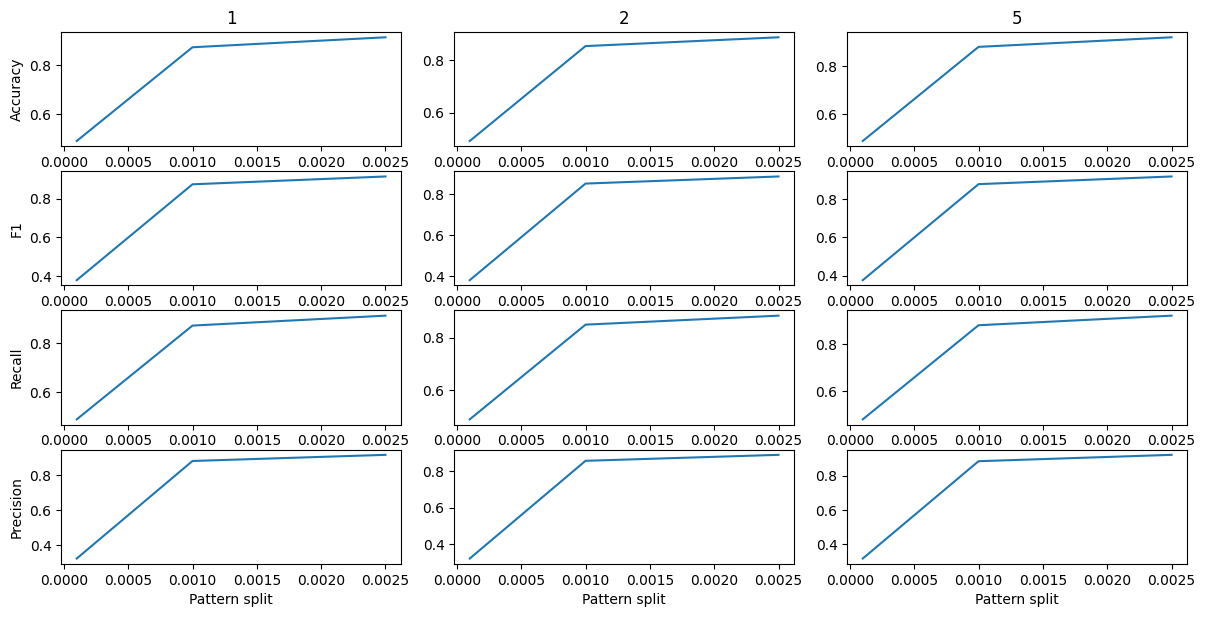

rule: classic, alpha: 0.01
{0.0001: (0.4905, 0.3803503294592265, 0.4856886635913499, 0.32626804441339763), 0.001: (0.8789, 0.8781052894575685, 0.8770775639716778, 0.8851831848377442), 0.0025: (0.9073, 0.9062374469048591, 0.905995944955443, 0.9077298095982907)}
{0.0001: (0.4905, 0.3803503294592265, 0.4856886635913499, 0.32626804441339763), 0.001: (0.88, 0.8789434342850384, 0.8780522381446987, 0.885133312419884), 0.0025: (0.9199, 0.9187824581888897, 0.9183571673997448, 0.9203867583412263)}
{0.0001: (0.4905, 0.3803503294592265, 0.4856886635913499, 0.32626804441339763), 0.001: (0.8804, 0.8792673249188013, 0.8784152604629231, 0.8855049437332209), 0.0025: (0.9229, 0.9221033487847817, 0.9217855503406254, 0.9232625621271907)}


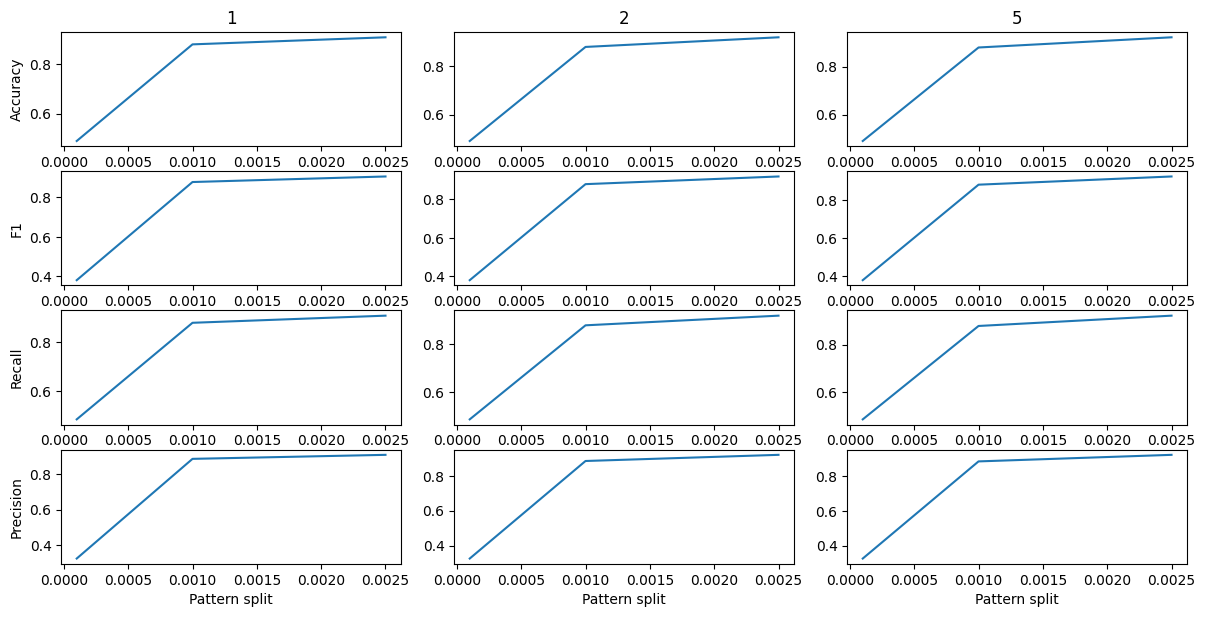

rule: classic, alpha: 0.05
{0.0001: (0.4517, 0.35583976865043554, 0.44927225078903454, 0.3161553476787764), 0.001: (0.8591, 0.8578439293582152, 0.8568012638294105, 0.8670215005335005), 0.0025: (0.9082, 0.9069848433597578, 0.9065356319781281, 0.9098256275553671)}
{0.0001: (0.4517, 0.35583976865043554, 0.44927225078903454, 0.3161553476787764), 0.001: (0.8543, 0.853256274669965, 0.8520059107017446, 0.8630963330364642), 0.0025: (0.9076, 0.9063400489110304, 0.9058631226282848, 0.9091928784741861)}
{0.0001: (0.4517, 0.35583976865043554, 0.44927225078903454, 0.3161553476787764), 0.001: (0.8516, 0.850494352495302, 0.849188211767587, 0.860782954392687), 0.0025: (0.9107, 0.9094906571062473, 0.9091463762902313, 0.9117324816669445)}


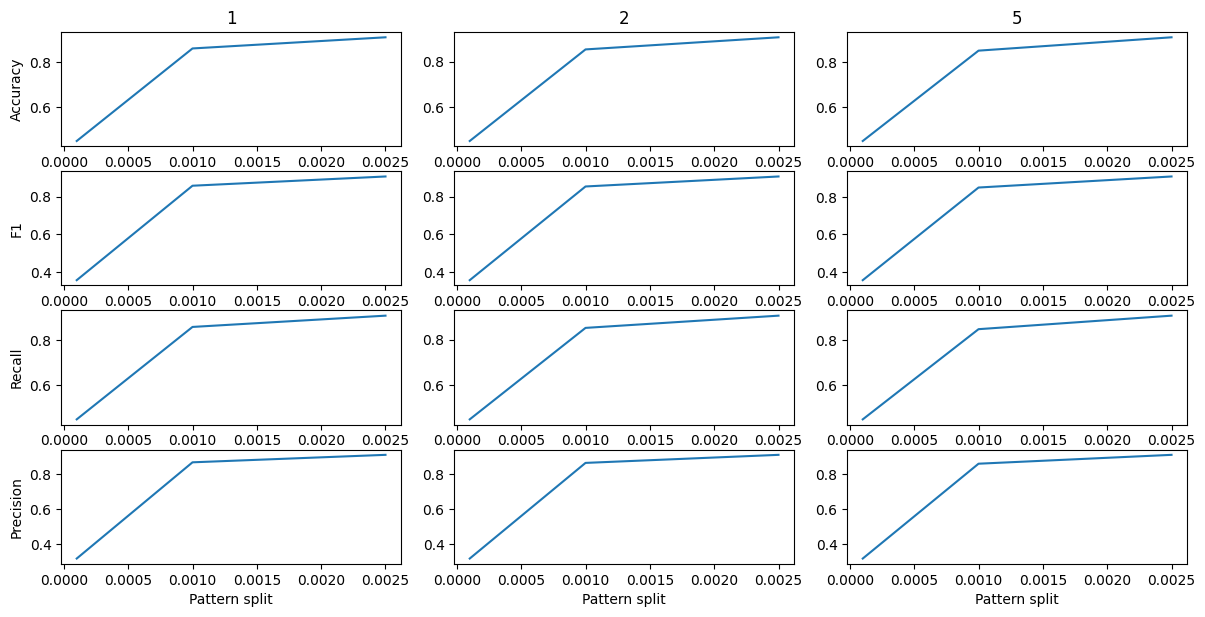

rule: two_step, alpha: 0.001
{0.0001: (0.4943, 0.4050834069478834, 0.49006642747092943, 0.36849723660387923), 0.001: (0.8126, 0.8108726002711311, 0.8095178535628863, 0.8193056690317639), 0.0025: (0.9223, 0.9211112529928298, 0.9211355171705502, 0.9220823985011444)}
{0.0001: (0.4964, 0.4056146951626016, 0.4921704618053207, 0.36754667387753837), 0.001: (0.8727, 0.8715960098569709, 0.8708403907958848, 0.8784988061786837), 0.0025: (0.9084, 0.9071175865952595, 0.9072104950094246, 0.9089422873247761)}
{0.0001: (0.496, 0.40556135494705464, 0.4917516787237797, 0.367708891517996), 0.001: (0.8818, 0.880444901020802, 0.8799812865099064, 0.8853436408035378), 0.0025: (0.9109, 0.9096640208664866, 0.9098054860255423, 0.9109007283489341)}


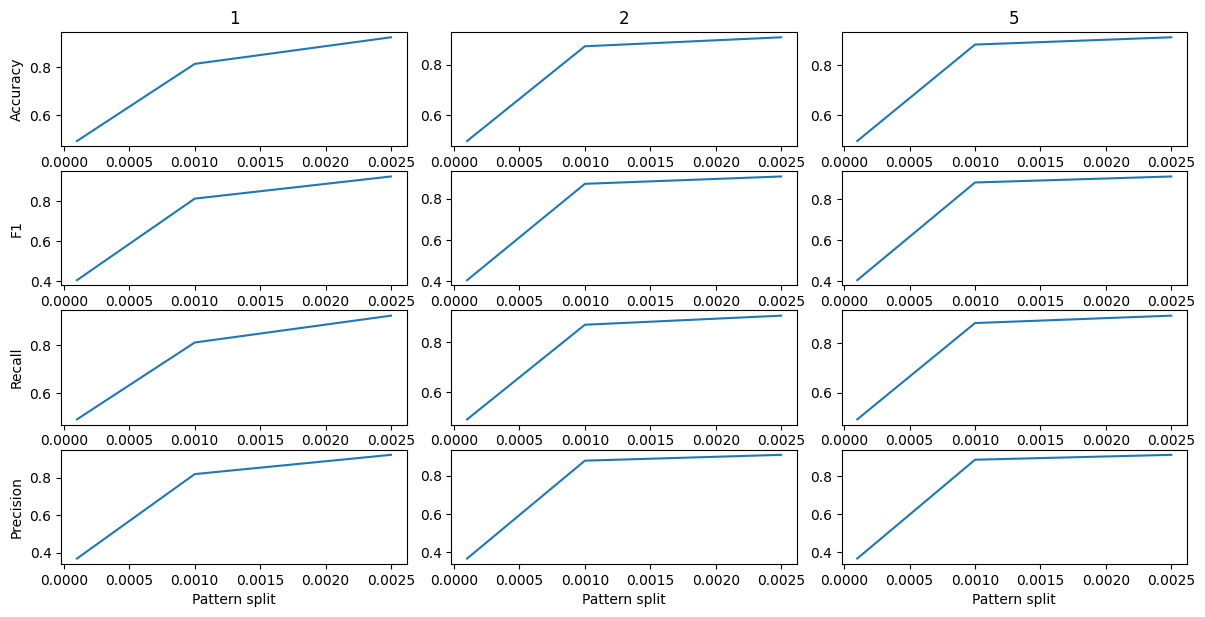

rule: two_step, alpha: 0.01
{0.0001: (0.4712, 0.3823968566051754, 0.4668703520123483, 0.347502548466109), 0.001: (0.8832, 0.8816774129458282, 0.8811423183138138, 0.8854110654585344), 0.0025: (0.9146, 0.9134450471144202, 0.913507031797856, 0.914389966386908)}
{0.0001: (0.4712, 0.3823968566051754, 0.4668703520123483, 0.347502548466109), 0.001: (0.8843, 0.8830381738709722, 0.8825100581136848, 0.8876176348145466), 0.0025: (0.9055, 0.9040349710733648, 0.9041366912692463, 0.905250321091929)}
{0.0001: (0.4712, 0.3823968566051754, 0.4668703520123483, 0.347502548466109), 0.001: (0.8735, 0.8719445399248954, 0.8712182413275015, 0.8781480082971933), 0.0025: (0.9221, 0.920913884326958, 0.9209520423516088, 0.9219153004549445)}


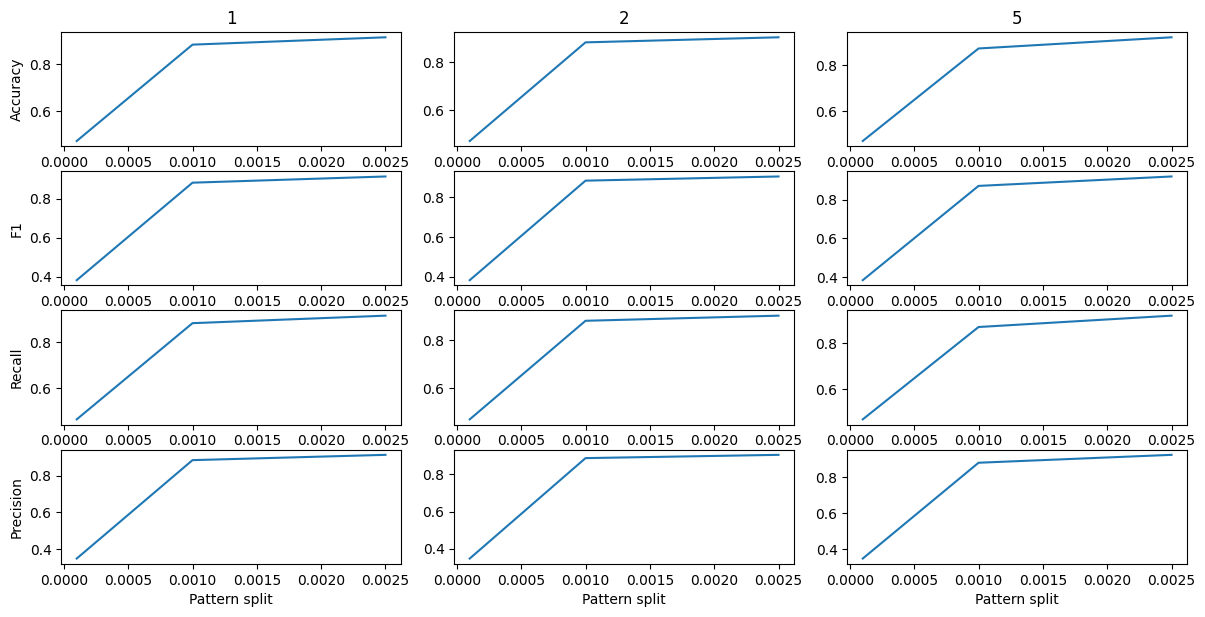

rule: two_step, alpha: 0.05
{0.0001: (0.4075, 0.3397690012676323, 0.4065113040702017, 0.3323325678621221), 0.001: (0.8399, 0.8377637362330356, 0.8369249791829283, 0.849252236745424), 0.0025: (0.9086, 0.90712099107697, 0.9070090098369048, 0.9085517241522704)}
{0.0001: (0.4075, 0.3397690012676323, 0.4065113040702017, 0.3323325678621221), 0.001: (0.8468, 0.844163255494338, 0.84359550346123, 0.8533227910431179), 0.0025: (0.9153, 0.9140831918168285, 0.9138150030833376, 0.9154714931158813)}
{0.0001: (0.4075, 0.3397690012676323, 0.4065113040702017, 0.3323325678621221), 0.001: (0.8409, 0.8390191281819666, 0.8380460899866247, 0.8503881536004242), 0.0025: (0.9085, 0.9068779334378251, 0.9067675415445546, 0.9084887834238604)}


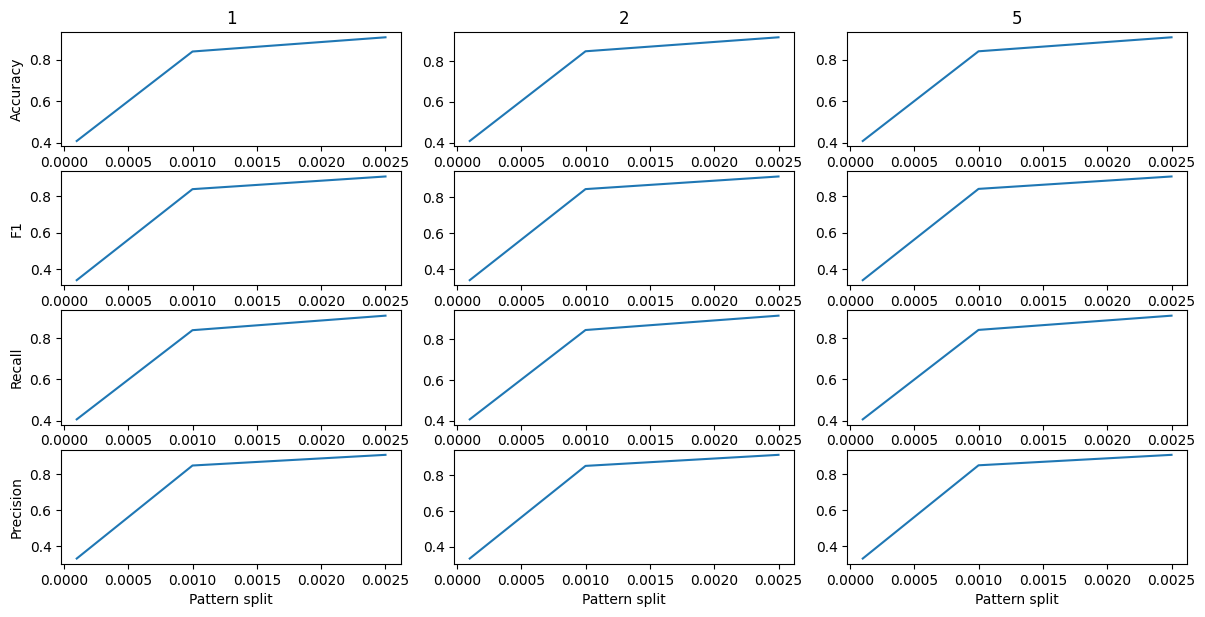

In [7]:
def visualize_dict_metrics(history):
    metric_names = ['Accuracy', 'F1', 'Recall', 'Precision']
    
    for rule, alphas_dict in history.items():
        for alpha, epochs_dict in alphas_dict.items():
            print(f'rule: {rule}, alpha: {alpha}')
            fig = plt.figure(figsize=(12, 6))

            for epochs, metrics in epochs_dict.items(): 
                offset = list(epochs_dict.keys()).index(epochs)
                print(metrics)

                plt.subplot(4, 3, 1 + offset)
                plt.plot(metrics.keys(), [metric[0] for metric in metrics.values()], label=f'{alpha} - {metric_names[0]}')
                plt.title(f'{epochs}')
                if offset == 0:
                    plt.ylabel(metric_names[0])

                plt.subplot(4, 3, 4 + offset)
                plt.plot(metrics.keys(), [metric[1] for metric in metrics.values()], label=f'{alpha} - {metric_names[1]}')
                if offset == 0:
                    plt.ylabel(metric_names[1])

                plt.subplot(4, 3, 7 + offset)
                plt.plot(metrics.keys(), [metric[2] for metric in metrics.values()], label=f'{alpha} - {metric_names[2]}')
                if offset == 0:
                    plt.ylabel(metric_names[2])

                plt.subplot(4, 3, 10 + offset)
                plt.plot(metrics.keys(), [metric[3] for metric in metrics.values()], label=f'{alpha} - {metric_names[3]}')
                if offset == 0:
                    plt.ylabel(metric_names[3])
                plt.xlabel('Pattern split')

            fig.tight_layout(pad=0.1)
            plt.show()


visualize_dict_metrics(history)